### Simple example of fitting an NVP flow to a 2D dataset

Paper is [here](https://arxiv.org/pdf/1605.08803).

In [24]:
import os
import torch
from torch import nn
from torch import distributions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm.notebook import trange
from sklearn.model_selection import train_test_split
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


FIGS_DIR = os.path.join(os.getcwd(), "figs/moons/")
if not os.path.exists(FIGS_DIR):
    os.makedirs(FIGS_DIR, exist_ok=True)
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
def convert(x):
    # Convert a numpy array to a torch tensor with float32 entries
    return torch.as_tensor(x).float()

##### Model

In [25]:
class net_s(nn.Module):
    def __init__(self,inp_shape=3,Dsize=[32,32,32],out_shape=2,activ_out=nn.Tanh(),activ_mid=nn.LeakyReLU()):
        super(net_s,self).__init__()
        Dsize.append(out_shape)
        self.Dlayers=nn.ModuleList(
            [nn.Linear(Dsize[i-1],Dsize[i]) if i>0 else nn.Linear(inp_shape,Dsize[i]) for i in range(len(Dsize))]
        )
        self.activ_mid=activ_mid
        self.activ_out=activ_out
    def forward(x,c):
        z=torch.cat((x,c),axis=1)
        for i,Dlayer in enumerate(self.Dlayers):
            z=self.activ_mid(Dlayer(z)) if i!=len(self.Dlayers)-1 else self.activ_out(Dlayer(z))
        return z
class net_t(nn.Module):
    def __init__(self,inp_shape=3,Dsize=[32,32,32],out_shape=2,activ_mid=nn.LeakyReLU()):
        super(net_t,self).__init__()
        Dsize.append(out_shape)
        self.Dlayers=nn.ModuleList(
            [nn.Linear(Dsize[i-1],Dsize[i]) if i>0 else nn.Linear(inp_shape,Dsize[i]) for i in range(len(Dsize))]
        )
        self.activ_mid=activ_mid
    def forward(x,c):
        z=torch.cat((x,c),axis=1)
        for i,Dlayer in enumerate(self.Dlayers):
            z=self.activ_mid(Dlayer(z)) if i!=len(self.Dlayers)-1 else Dlayer(z)
        return z



In [26]:
class RealNVP(nn.Module):
    def __init__(self, net_s, net_t, masks, prior):
        super(RealNVP, self).__init__()
        # Base distribution, a data-dimensional Gaussian
        self.prior = prior
        # Masks are not to be optimised
        self.mask = nn.Parameter(masks, requires_grad=False)
        # The s and t nets that parameterise the scale and shift
        # change of variables according to inputs, here we are
        # duplicating the networks for each layer.
        self.t = torch.nn.ModuleList(
            [net_t() for _ in range(len(masks))]
        )
        self.s = torch.nn.ModuleList(
            [net_s() for _ in range(len(masks))]
        )

    def reverse(self, z):
        # Map from Gaussian distributed z to data x
        x = z
        for i in range(len(self.t)):
            x_ = x * self.mask[i]
            s = self.s[i](x_)          * (1 - self.mask[i])
            t = self.t[i](x_) * (1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def forward(self, x):
        # Map from data x to Gaussian distributed z
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1 - self.mask[i])
            t = self.t[i](z_) * (1 - self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self, x):
        # Calculate log-probability of x under flow distribution
        z, log_det_J = self.forward(x)
        return self.prior.log_prob(z) + log_det_J

    def sample(self, n):
        # Sample n points from flow distribution fit to data
        z = self.prior.sample((n, 1))
        x = self.reverse(z)
        return x

##### Setup

In [27]:
H = 256            # Hidden dimension
L = 4              # Number of transforms in flow
n_data = 10000     # Number of datapoints in training set
n_steps = 10000    # Number of batches to run for
batch_size = 1000  # Number of datapoints in batch

# Scaling and shifting networks for flow change of variables
# net_s = lambda: nn.Sequential(
#     nn.Linear(2, H), nn.LeakyReLU(),
#     nn.Linear(H, H), nn.LeakyReLU(),
#     nn.Linear(H, 2), nn.Tanh()
# )
# net_t = lambda: nn.Sequential(
#     nn.Linear(2, H), nn.LeakyReLU(),
#     nn.Linear(H, H), nn.LeakyReLU(),
#     nn.Linear(H, 2)
# )

# Masking for NVP flow model
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * L)).float()

# Base distribution for normalizing flow
prior = distributions.MultivariateNormal(
    torch.zeros(2).to(device), torch.eye(2).to(device)
)

# Build the model
flow = RealNVP(net_s, net_t, masks, prior).to(device)

# Get some training data
X, Y = make_moons(n_data, noise=0.05)

# Scale the data to [-1, 1] 
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

# Convert it to tensors and move to device
X, Y = convert(X).to(device), convert(Y.reshape(-1,1)).to(device)

def get_data(n_batch):
    # A simple dataloader
    ix = torch.randint(low=0, high=n_data, size=(n_batch,))
    x, y = X[ix], Y[ix]
    return x, y

optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)

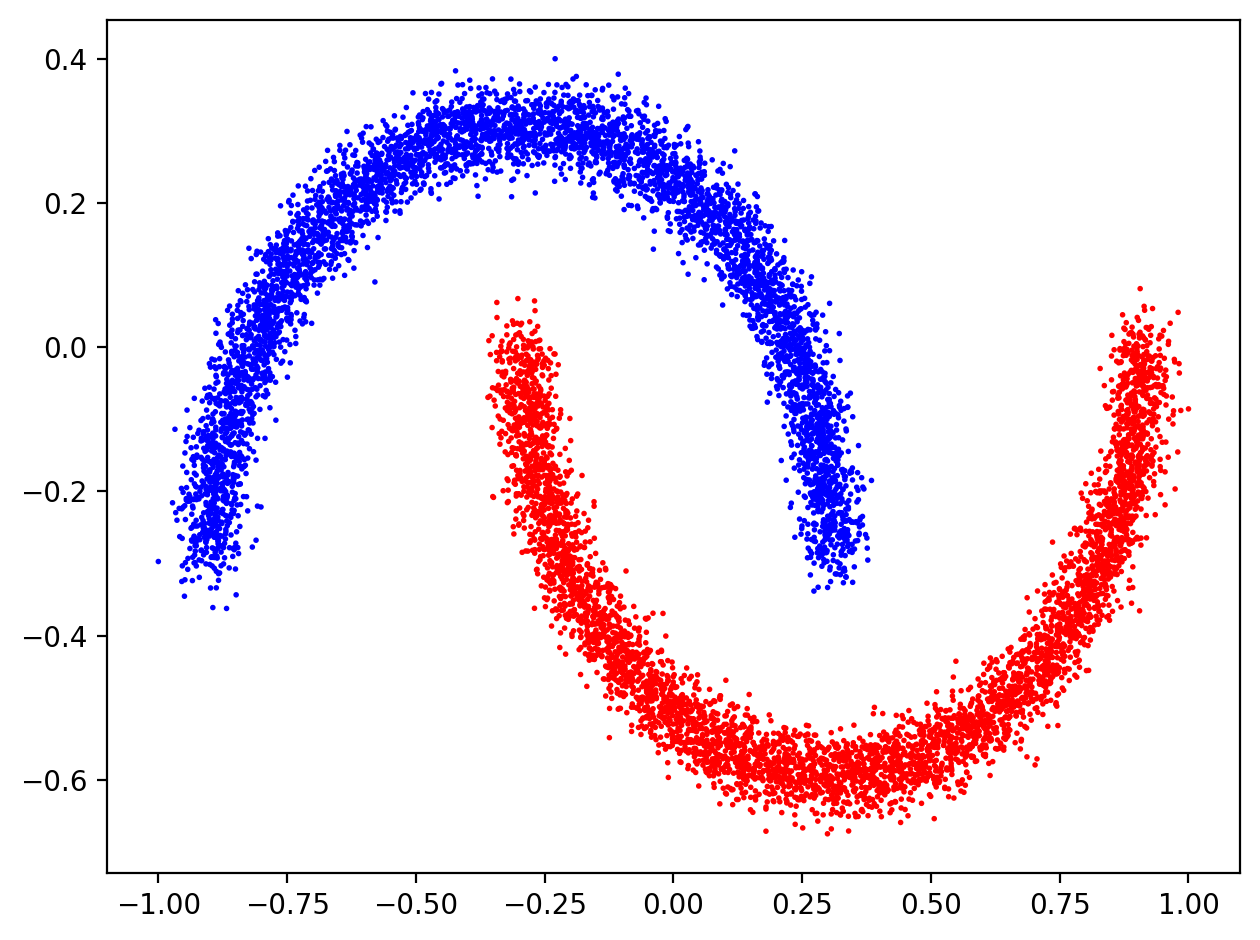

In [28]:
# Plot some training samples for comparison
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*X.cpu().numpy().T, c=Y.cpu().numpy(), s=1., cmap="bwr")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "train_samples_moons.png"))
plt.show()

####  data prepropcessing

In [29]:
def train_val_test_split(datapoints, labels, train_size=0.7, val_size=0.15, test_size=0.15, random_state=None):
  '''
  datapoints and labels are in np.array form, the datas are randomly distributed as train,val and test datasets
  according to the train_size,val_size,test_size.

  output: datapoints_train, labels_train, datapoints_val, labels_val, datapoints_test, labels_test, all are in np.array form
  '''
  assert train_size + val_size + test_size == 1, "Train, validation, and test sizes must sum to 1"

  datapoints_train, datapoints_temp, labels_train, labels_temp = train_test_split(
      datapoints, labels, train_size=train_size, random_state=random_state)

  relative_val_size = val_size / (val_size + test_size)

  datapoints_val, datapoints_test, labels_val, labels_test = train_test_split(
      datapoints_temp, labels_temp, train_size=relative_val_size, random_state=random_state)

  return datapoints_train, labels_train, datapoints_val, labels_val, datapoints_test, labels_test
xtr,ytr,xval,yval,xte,yte=train_val_test_split(X, Y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=None)

#### Train

In [30]:
def get_piecewise_scheduler(optimizer, boundaries, factor):
    """
    Create a piecewise learning rate scheduler based on given boundaries and LR values.

    Args:
    - optimizer: PyTorch optimizer object.
    - boundaries: List of epoch indices to change the LR value.
    - factor: List of decay factors of lr corresponding to each boundary.

    Returns:
    - scheduler: PyTorch scheduler object (LambdaLR).
    """
    def lr_lambda(epoch):
        for i, boundary in enumerate(boundaries):
            if epoch < boundary:
                return factor[i] 
        return factor[-1]

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    return scheduler

In [31]:
class net_s(nn.Module):
    def __init__(self,inp_shape=3,Dsize=[32,32,32],out_shape=2,activ_out=nn.Tanh(),activ_mid=nn.LeakyReLU()):
        super(net_s,self).__init__()
        Dsize.append(out_shape)
        self.Dlayers=nn.ModuleList(
            [nn.Linear(Dsize[i-1],Dsize[i]) if i>0 else nn.Linear(inp_shape,Dsize[i]) for i in range(len(Dsize))]
        )
        self.activ_mid=activ_mid
        self.activ_out=activ_out
    def forward(self,x,c):
        z=torch.cat((x,c),axis=1)
        for i,Dlayer in enumerate(self.Dlayers):
            z=self.activ_mid(Dlayer(z)) if i!=len(self.Dlayers)-1 else self.activ_out(Dlayer(z))
        return z
class net_t(nn.Module):
    def __init__(self,inp_shape=3,Dsize=[32,32,32],out_shape=2,activ_mid=nn.LeakyReLU()):
        super(net_t,self).__init__()
        Dsize.append(out_shape)
        self.Dlayers=nn.ModuleList(
            [nn.Linear(Dsize[i-1],Dsize[i]) if i>0 else nn.Linear(inp_shape,Dsize[i]) for i in range(len(Dsize))]
        )
        self.activ_mid=activ_mid
    def forward(self,x,c):
        z=torch.cat((x,c),axis=1)
        for i,Dlayer in enumerate(self.Dlayers):
            z=self.activ_mid(Dlayer(z)) if i!=len(self.Dlayers)-1 else Dlayer(z)
        return z

class NVP(nn.Module):
    def __init__(self,inp_shape_s=3,Dsize_s=[32,32,32],out_shape_s=2,activ_out_s=nn.Tanh(),activ_mid_s=nn.LeakyReLU(),
                 inp_shape_t=3,Dsize_t=[32,32,32],out_shape_t=2,activ_mid_t=nn.LeakyReLU(),
                 net_s=net_s,net_t=net_t,masks=torch.as_tensor(np.array([[0,1],[1,0]]*3)).to(device),prior=distributions.MultivariateNormal(
    torch.zeros(2).to(device), torch.eye(2).to(device))
):
        super(NVP, self).__init__()
        # Base distribution, a data-dimensional Gaussian
        self.prior = prior
        # Masks are not to be optimised
        self.mask = nn.Parameter(masks, requires_grad=False)
        # The s and t nets that parameterise the scale and shift
        # change of variables according to inputs, here we are
        # duplicating the networks for each layer.
        self.s = torch.nn.ModuleList(
            [net_s(inp_shape=inp_shape_s, Dsize=Dsize_s, out_shape=out_shape_s, activ_out=activ_out_s, activ_mid=activ_mid_s)
             for _ in range(len(masks))]
        )
        self.t = torch.nn.ModuleList(
            [net_t(inp_shape=inp_shape_t, Dsize=Dsize_t, out_shape=out_shape_t, activ_mid=activ_mid_t)
             for _ in range(len(masks))]
        )
    def reverse(self, z,c):
        # Map from Gaussian distributed z to data x
        x = z
        for i in range(len(self.t)):
            x_ = x * self.mask[i]
            s = self.s[i](x_,c) * (1 - self.mask[i])
            t = self.t[i](x_,c) * (1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def forward(self, x,c):
        # Map from data x to Gaussian distributed z
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_,c) * (1 - self.mask[i])
            t = self.t[i](z_,c) * (1 - self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self, x,c):
        # Calculate log-probability of x under flow distribution
        z, log_det_J = self.forward(x,c)
        return self.prior.log_prob(z) + log_det_J

    def sample(self, n,c):
        # Sample n points from flow distribution fit to data
        z = self.prior.sample((n,))
        x = self.reverse(z,c)
        return x

In [32]:
seed=42
lr=1e-3
patience_lr=10
factor=0.6
epochs=200
batch_size=512
patience=20

if seed!=None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

train_dataset = TensorDataset(xtr,ytr)
val_dataset = TensorDataset(xval,yval)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
flow = NVP().to(device)

best_model = copy.deepcopy(flow)
optimizer = optim.Adam(flow.parameters(), lr=lr)

if isinstance(patience_lr, list):
    scheduler=get_piecewise_scheduler(optimizer,patience_lr,factor)
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=factor,patience=patience_lr)


losses = []

# Training loop with early stopping and learning rate scheduling
best_loss = float('inf')
best_tr_loss= float('inf')
epochs_no_improve = 0

global_train_loss = []
global_val_loss = []

#begin truaining
for epoch in range(epochs):
    flow.train()
    train_loss = 0
    for xtrb, ytrb in train_loader:
        xtrb = xtrb.to(device)
        ytrb=ytrb.to(device)
        
        optimizer.zero_grad()
        loss=-flow.log_prob(xtrb,ytrb).mean()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    global_train_loss.append(train_loss)

    flow.eval()
    val_loss = 0
    with torch.no_grad():
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        for xvalb,yvalb in val_loader:
            xvalb = xvalb.to(device)
            yvalb = yvalb.to(device)
            loss=-flow.log_prob(xvalb,yvalb).mean()
            val_loss += loss.item()

        val_loss /= len(val_loader)
        if isinstance(patience_lr,list):
            scheduler.step(epoch)
        else:
            scheduler.step(val_loss)
            lr_ = optimizer.param_groups[0]['lr']
            global_val_loss.append(val_loss)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, LR: {lr_:.3e}")

        # Early stopping and learning rate scheduling
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = flow
        # evalu_tc(best_model,val_loader,m_mean.numpy().astype('float32'),1.,filename=None)
            epochs_no_improve = 0
        elif train_loss>best_tr_loss+0.15:
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            best_tr_loss=train_loss
        if epochs_no_improve >= patience and epoch>=35:
            print("Early stopping triggered")
            break




Epoch 1, Train Loss: 2.5837, Validation Loss: 2.3574, LR: 1.000e-03
Epoch 2, Train Loss: 2.1510, Validation Loss: 1.9132, LR: 1.000e-03
Epoch 3, Train Loss: 1.7121, Validation Loss: 1.4911, LR: 1.000e-03
Epoch 4, Train Loss: 1.3344, Validation Loss: 1.1671, LR: 1.000e-03
Epoch 5, Train Loss: 1.0445, Validation Loss: 0.9014, LR: 1.000e-03
Epoch 6, Train Loss: 0.7776, Validation Loss: 0.6221, LR: 1.000e-03
Epoch 7, Train Loss: 0.4787, Validation Loss: 0.3132, LR: 1.000e-03
Epoch 8, Train Loss: 0.2510, Validation Loss: 0.1876, LR: 1.000e-03
Epoch 9, Train Loss: 0.1679, Validation Loss: 0.1191, LR: 1.000e-03
Epoch 10, Train Loss: 0.0815, Validation Loss: 0.0060, LR: 1.000e-03
Epoch 11, Train Loss: -0.0716, Validation Loss: -0.2356, LR: 1.000e-03
Epoch 12, Train Loss: -0.3986, Validation Loss: -0.6003, LR: 1.000e-03
Epoch 13, Train Loss: -0.7098, Validation Loss: -0.8398, LR: 1.000e-03
Epoch 14, Train Loss: -0.8829, Validation Loss: -0.9176, LR: 1.000e-03
Epoch 15, Train Loss: -0.9711, Vali

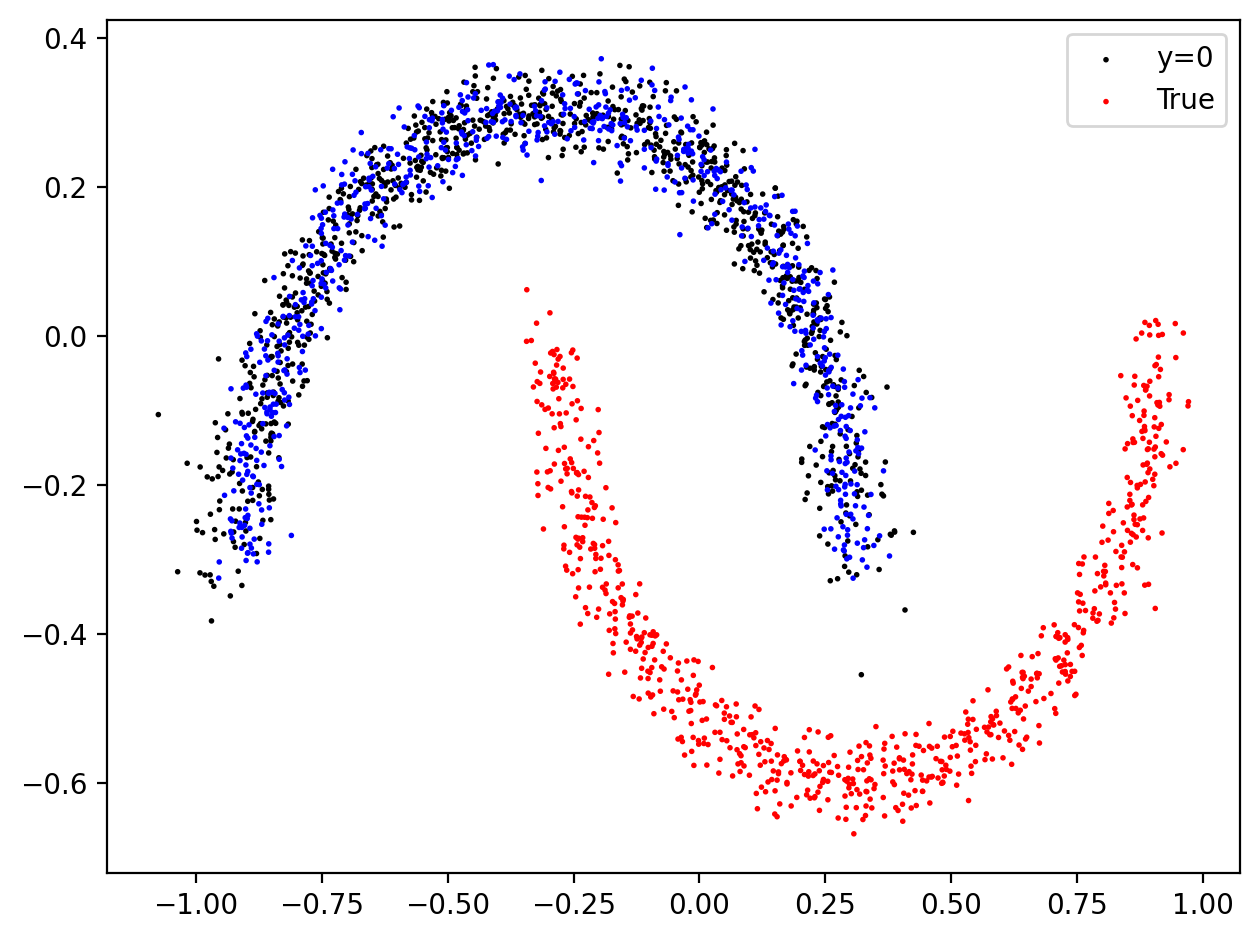

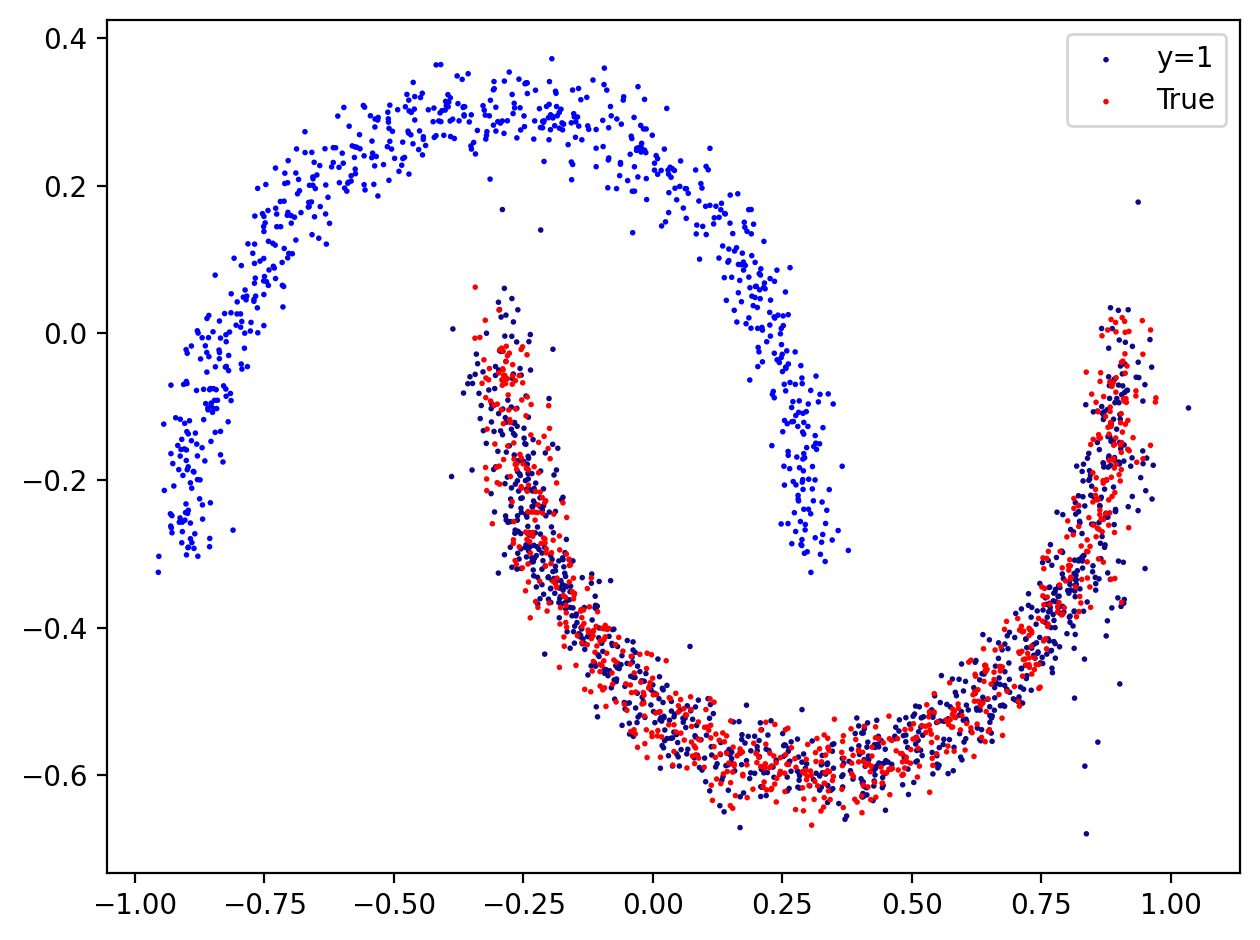

In [34]:
y_samp1=torch.zeros(1000,1).to(device)
x_samp1=flow.sample(1000,y_samp1)
y_samp2=torch.ones(1000,1).to(device)
x_samp2=flow.sample(1000,y_samp2)
# Plot some training samples for comparison
fig, ax1 = plt.subplots(1, 1, dpi=200)
ax1.scatter(*x_samp1.detach().cpu().numpy().T, c=y_samp1.cpu().numpy().flatten(), s=1., cmap='CMRmap', label='y=0',alpha=1)
# ax1.scatter(*x_samp2.detach().cpu().numpy().T, c=y_samp2.cpu().numpy().flatten(), s=1., cmap='plasma', label='y=1')
ax1.scatter(*xte.cpu().numpy().T, c=yte.cpu().numpy().flatten(), s=1., cmap="bwr", label='True')
ax1.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "train_samples_moons.png"))
plt.show()

fig, ax1 = plt.subplots(1, 1, dpi=200)
# ax1.scatter(*x_samp1.detach().cpu().numpy().T, c=y_samp1.cpu().numpy().flatten(), s=1., cmap='CMRmap', label='y=0',alpha=1)
ax1.scatter(*x_samp2.detach().cpu().numpy().T, c=y_samp2.cpu().numpy().flatten(), s=1., cmap='plasma', label='y=1')
ax1.scatter(*xte.cpu().numpy().T, c=yte.cpu().numpy().flatten(), s=1., cmap="bwr", label='True')
ax1.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "train_samples_moons.png"))
plt.show()

#### Inference

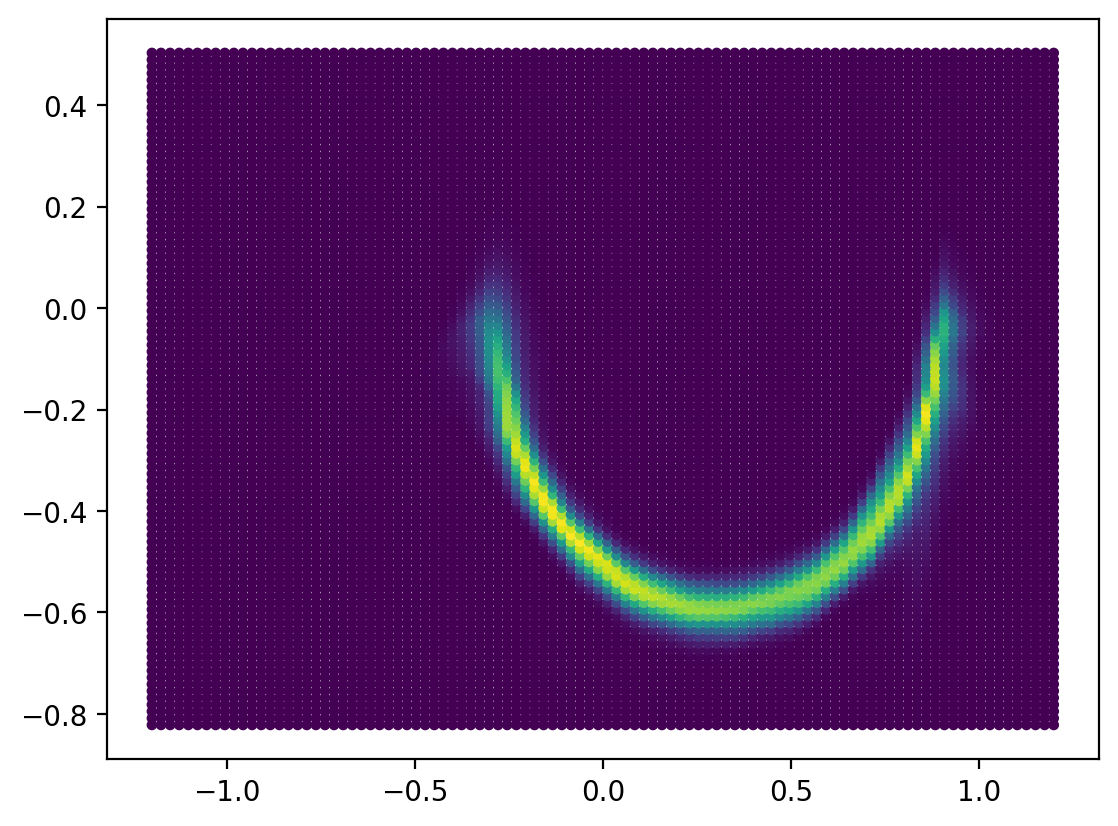

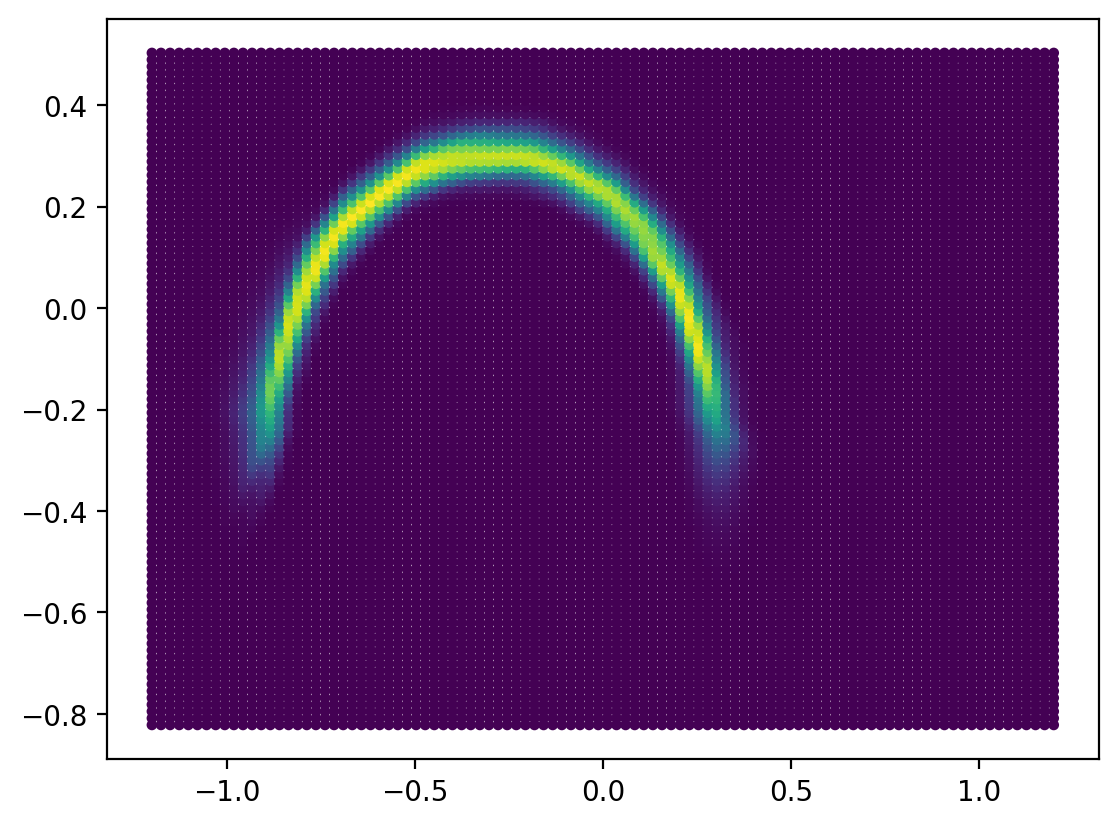

In [42]:
# Plot the likelihood over data space
X, Y = make_moons(n_data, noise=0.05)
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

# Get a grid of points spanning the data space
X1, X2 = X.T
dx = 0.1 * (X1.max() - X1.min()) # Same span as data plus a little bit extra
dy = 0.1 * (X2.max() - X2.min())
X_, Y_ = np.mgrid[X1.min() - dx:X1.max() + dx:100j, X2.min() - dy:X2.max() + dy:100j]
X = torch.as_tensor(np.vstack([X_.ravel(), Y_.ravel()])).float().T
y1=torch.ones(10000,1).to(device)
# Flow likelihood
L_x = np.exp(flow.log_prob(X.to(device),y1).cpu().detach().numpy())

plt.figure(dpi=200)
plt.scatter(*X.numpy().T, c=L_x, s=8.)
plt.savefig(os.path.join(FIGS_DIR, "likelihood_moons1.png"))
plt.show()

y0=torch.zeros(10000,1).to(device)
# Flow likelihood
L_x = np.exp(flow.log_prob(X.to(device),y0).cpu().detach().numpy())

plt.figure(dpi=200)
plt.scatter(*X.numpy().T, c=L_x, s=8.)
plt.savefig(os.path.join(FIGS_DIR, "likelihood_moons0.png"))
plt.show()

TypeError: NVP.sample() missing 1 required positional argument: 'c'

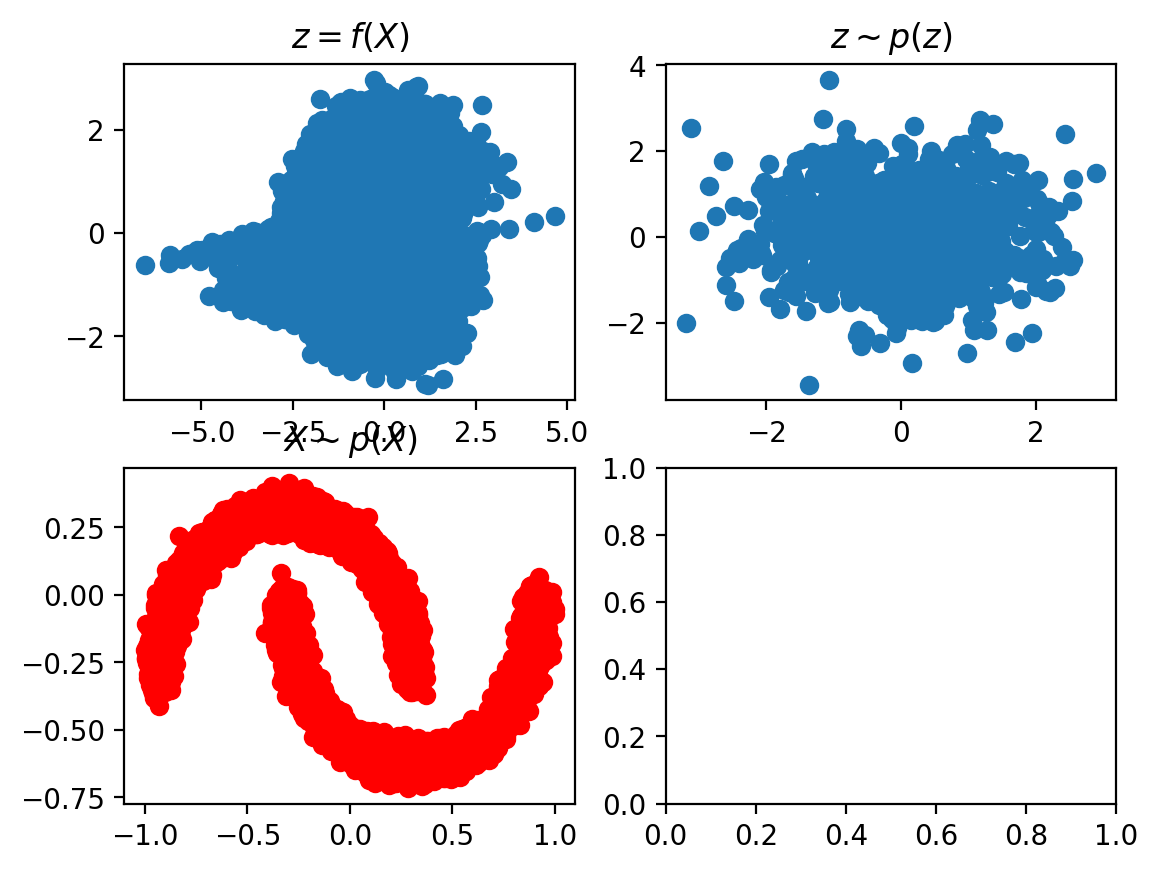

In [50]:
X, Y = make_moons(n_data, noise=0.05)
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.
Y=Y.reshape(-1,1)
X = torch.as_tensor(X).float().to(device)
Y = torch.as_tensor(Y).float().to(device)
plt.figure(dpi=200)

# Data mapped to prior 'latent' space
z, log_det_J= flow.forward(X,Y)
z=z.cpu().detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

# Prior
z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

# Truth distribution
plt.subplot(223)
X = X.cpu()
plt.scatter(X[:, 0], X[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

# Generated
plt.subplot(224)
X = flow.sample(1000).cpu().detach().numpy().squeeze()
plt.scatter(X[:, 0], X[:, 1], c='r')
plt.title(r'$X = g(z)$')

plt.savefig(os.path.join(FIGS_DIR, "flow_mappings.png"))
plt.show()

In [47]:
X.shape,Y.shape

(torch.Size([10000, 2]), torch.Size([10000]))